In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shilpu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
df = pd.read_csv('trainingDataset.csv', error_bad_lines=False)
data = df.abstract.values.tolist()
# Remove Emails
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub(r"\'", "", sent) for sent in data]
data = [re.sub(r"[^\sa-zA-Z0-9-.,)(!]","",sent) for sent in data]
pprint(data[:1])

['Barack Hussein Obama II ( (listen) born August 4, 1961) is an American '
 'politician and attorney who served as the 44th president of the United '
 'States from 2009 to 2017.']


In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['barack', 'hussein', 'obama', 'ii', 'listen', 'born', 'august', 'is', 'an', 'american', 'politician', 'and', 'attorney', 'who', 'served', 'as', 'the', 'th', 'president', 'of', 'the', 'united', 'states', 'from', 'to']]


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# A trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['barack', 'hussein', 'obama', 'ii', 'listen', 'born', 'august', 'is', 'an', 'american', 'politician', 'and', 'attorney', 'who', 'served', 'as', 'the', 'th', 'president', 'of', 'the', 'united_states', 'from', 'to']


In [7]:
# Functions for removing stopwords, creating bigrams, creating trigrams and performing lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keep only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['listen', 'bear', 'american', 'politician', 'attorney', 'serve']]


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
print(id2word)

# Create Corpus based on lemmatized data
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View a part of the corpus
print(corpus[:1])

Dictionary(1537 unique tokens: ['american', 'attorney', 'bear', 'listen', 'politician']...)
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [10]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('american', 1),
  ('attorney', 1),
  ('bear', 1),
  ('listen', 1),
  ('politician', 1),
  ('serve', 1)]]

In [20]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=120, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [21]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(6,
  '0.001*"grandmaster" + 0.001*"consider" + 0.001*"kreln" + 0.001*"champion" + '
  '0.001*"chess" + 0.001*"individual" + 0.001*"artistic" + 0.001*"multiple" + '
  '0.001*"honored" + 0.001*"great"'),
 (112,
  '0.001*"grandmaster" + 0.001*"consider" + 0.001*"kreln" + 0.001*"champion" + '
  '0.001*"chess" + 0.001*"individual" + 0.001*"artistic" + 0.001*"multiple" + '
  '0.001*"honored" + 0.001*"great"'),
 (64,
  '0.001*"grandmaster" + 0.001*"consider" + 0.001*"kreln" + 0.001*"champion" + '
  '0.001*"chess" + 0.001*"individual" + 0.001*"artistic" + 0.001*"multiple" + '
  '0.001*"honored" + 0.001*"great"'),
 (16,
  '0.001*"grandmaster" + 0.001*"consider" + 0.001*"kreln" + 0.001*"champion" + '
  '0.001*"chess" + 0.001*"individual" + 0.001*"artistic" + 0.001*"multiple" + '
  '0.001*"honored" + 0.001*"great"'),
 (89,
  '0.001*"grandmaster" + 0.001*"consider" + 0.001*"kreln" + 0.001*"champion" + '
  '0.001*"chess" + 0.001*"individual" + 0.001*"artistic" + 0.001*"multiple" + '
  '0.001*"hon

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Perplexity:  -238.2729949951172

Coherence Score:  0.7320373140121686


In [14]:
#Load the LDA Mallet library from the mallet path
import os
from gensim.models.wrappers import LdaMallet
os.environ['MALLET_HOME'] = 'C:\\Users\\Shilpu\\NLPProject\\QuestionAnsweringSystem\\mallet-2.0.8\\mallet-2.0.8'
mallet_path = 'C:\\Users\\Shilpu\\NLPProject\\QuestionAnsweringSystem\\mallet-2.0.8\\mallet-2.0.8\\bin\\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [15]:
pprint(ldamallet.show_topics(formatted=False))
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(15,
  [('athlete', 0.12912912912912913),
   ('title', 0.11411411411411411),
   ('irish', 0.057057057057057055),
   ('peerage', 0.05405405405405406),
   ('iranian', 0.03903903903903904),
   ('medal', 0.03303303303303303),
   ('world', 0.03003003003003003),
   ('win', 0.02702702702702703),
   ('olympic', 0.024024024024024024),
   ('gold', 0.018018018018018018)]),
 (2,
  [('member', 0.4166666666666667),
   ('parliament', 0.10483870967741936),
   ('italian', 0.026881720430107527),
   ('deputy', 0.026881720430107527),
   ('tamil', 0.021505376344086023),
   ('constituency', 0.021505376344086023),
   ('model', 0.01881720430107527),
   ('ride', 0.016129032258064516),
   ('mayor', 0.013440860215053764),
   ('hold', 0.010752688172043012)]),
 (0,
  [('canadian', 0.2979942693409742),
   ('lawyer', 0.13753581661891118),
   ('elect', 0.06017191977077364),
   ('election', 0.054441260744985676),
   ('diplomat', 0.04011461318051576),
   ('businessman', 0.03151862464183381),
   ('official', 0.02578796

In [16]:
#Computing coherence scores based on number of topics.
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=50, limit=180, step=10)

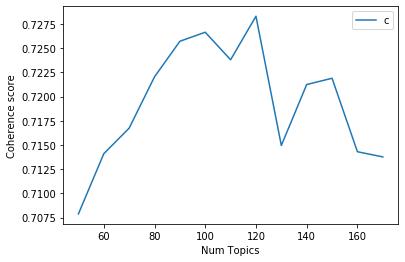

In [18]:
# Show graph
limit=180; start=50; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 50  has Coherence Value of 0.7079
Num Topics = 60  has Coherence Value of 0.7141
Num Topics = 70  has Coherence Value of 0.7167
Num Topics = 80  has Coherence Value of 0.722
Num Topics = 90  has Coherence Value of 0.7257
Num Topics = 100  has Coherence Value of 0.7266
Num Topics = 110  has Coherence Value of 0.7238
Num Topics = 120  has Coherence Value of 0.7283
Num Topics = 130  has Coherence Value of 0.7149
Num Topics = 140  has Coherence Value of 0.7212
Num Topics = 150  has Coherence Value of 0.7219
Num Topics = 160  has Coherence Value of 0.7143
Num Topics = 170  has Coherence Value of 0.7138


In [20]:
# Select the model and print the topics
optimal_model = model_list[9]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(101,
  '0.310*"september" + 0.050*"newspaper" + 0.040*"gilbert" + 0.030*"finnish" + '
  '0.030*"ugandan" + 0.030*"la" + 0.020*"liberal" + 0.020*"st" + '
  '0.020*"pronunciation" + 0.020*"tory"'),
 (149,
  '0.271*"politician" + 0.188*"august" + 0.047*"thai" + 0.024*"osbaldeston" + '
  '0.024*"mitchell" + 0.024*"silkin" + 0.024*"ross" + 0.012*"master" + '
  '0.012*"jaggesh" + 0.012*"rowland"'),
 (105,
  '0.180*"retire" + 0.131*"professional" + 0.057*"japanese" + 0.049*"wrestler" '
  '+ 0.041*"wrestling" + 0.033*"inoki" + 0.033*"art" + 0.025*"martial" + '
  '0.025*"trade" + 0.016*"murakawa"'),
 (182,
  '0.161*"author" + 0.046*"radio" + 0.046*"december" + 0.046*"owner" + '
  '0.034*"public" + 0.034*"comedian" + 0.023*"north" + 0.023*"marquez" + '
  '0.023*"april" + 0.023*"professional"'),
 (121,
  '0.156*"elect" + 0.156*"election" + 0.078*"general" + 0.055*"federal" + '
  '0.055*"commons" + 0.047*"represent" + 0.047*"electoral_district" + '
  '0.031*"dil" + 0.023*"agricultural" + 0.023*"